# The King County Case Study

![King County Skyline](assessors_social-1.jpg)

## Goal of the Analysis

As per the customers requirements, the focus of the analysis is on identifying houses that are affordable and are situated in a kid-friendly and social environment. Initial points of interest are for example when and where it would be recommendable to buy a house, given these requirements.

### Agenda
* **First look at the data**
* **Formulating assumptions and areas to investigate**
* **Cleaning and preparing the data**
* **Analysis & revisiting the assumptions**
* **Recommendations**

## First look at the data

In a first step, we import the required packages and load the data into a dataframe.

In [2]:
# Importing required packages

import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import FastMarkerCluster

In [3]:
# Loading data into a dataframe
df = pd.read_csv("data/King_County_House_prices_dataset.csv")

To get a feel for the data we have a look at the first rows.

In [4]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


## Formulating assumptions and areas to investigate

Based on the first look at the data set and the requirement of the customer, we make the following assumptions:
1. **The average prices for houses are different for different months.** As the customer is asking when to buy, there might be time frame where houses are cheaper.
2. **The location of the house influences its price.** In addition, the customer would like to narrow down where they should look for houses, as some areas might be cheaper than others.
3. **Renovated houses will be more expensive.** This is important because by purchasing a non-renovated house and potentially doing the renovation themselves, the customer might be able to afford a house with a larger living area.
4. **The additional benefit of a waterfront will make a house more expensive.** Again, by choosing to go without a waterfront, the customer might be able to afford a larger living area (house).

## Cleaning and preparing the data

### Identifying missing values and adjusting data types

To identify whether there are columns with missing data, we take a look at the Non-Null Count provided by the overall information of the dataframe. This also provides us the current data types that are contained in each column.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

**Missing values**: There are 3 columns that have missing values, ```waterfront, view, yr_renovated```. The ```waterfront``` column indicates whether the house has a waterfront. We make the assumption that if there is no value given, the house does not have a waterfront. The same reasoning applies for the ```view``` column, which we interpret as how often the house has been on the market before it was sold. This could be houses that have been sold without having been officially on the market. The low number of missing values (63) supports this assumption. Lastly, the ```yr_renovated``` column shows when the house was last renovated before sale. Here, we assume that the house was not renovated yet or the date of renovation is not documented, which amounts to the same outcome. As a result, we fill all missing values in these three columns with the value ```0```. 

**Adjusting data types**: The ```sqft_basement``` column is of datatype object. On further inspection it turns out that it contains some numbers formatted as strings and some ```?```. Thus we can simply convert all values to integers and replace the unknown values with 0. For cosmetic reasons, we also readjust the data type of the price column to full integers.

In [6]:
# Replacing missing values with 0
df.waterfront = df.waterfront.fillna(0).astype("int8")
df.view = df.view.fillna(0).astype("int8")
df.yr_renovated = df.yr_renovated.fillna(0).astype("int16")

# Changing data type of price column to int
df.price = df.price.astype("int64")
df.sqft_basement = pd.to_numeric(df.sqft_basement, errors='coerce').fillna(0).astype("int32")

### Identifying and removing outliers 

In order to find outliers and extreme values, we perform some preliminary numerical and graphical analysis. As a first step, we look at the description of the data sets statistics.

In [7]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.006760,0.233181,3.409825,7.657915,1788.596842,285.716581,1970.999676,68.758207,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.081944,0.764673,0.650546,1.173200,827.759761,439.819830,29.375234,364.037499,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,550.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


A quick look at the largest values of the bedroom column shows that there is one house with 33 bedrooms.

In [8]:
df.bedrooms.sort_values(ascending=False).head(3)

15856    33
8748     11
19239    10
Name: bedrooms, dtype: int64

Whether this was a large mansion or it is an error in the data does not matter - it will not help us analyze prices of the types of houses our customer is looking for. Therefore we remove the row from the data set.

In [9]:
df = df[df.bedrooms < 33]

We further see that the columns ```bedrooms, bathrooms, floors, waterfront, view, condition, grade``` have values that lie within a small interval. Except for ```view```, the quartiles for these columns look reasonable as well. Therefore, we will not investigate them closer in the preliminary graphical analysis.

The columns ```date, zipcode, lat, long``` provide time or location context for the other columns and do not show any irregularities when looking at their statistics. They will hence not be evaluated for outliers.

To get a better picture of the remaining columns ```price, sqft_living, sqft_lot, sqft_above, sqft_basement, yr_built, yr_renovated, sqft_living15, sqft_lot15```, we plot their box plots.

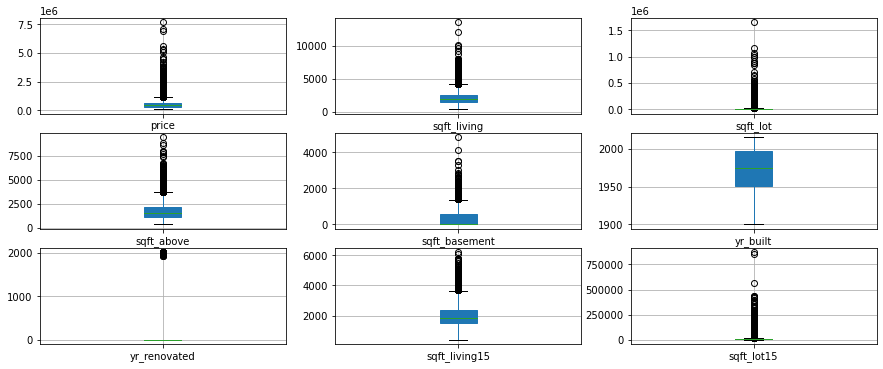

In [10]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(15,6))

df.boxplot(column=['price'],ax=axes[0,0],patch_artist=True)
df.boxplot(column=['sqft_living'],ax=axes[0,1],patch_artist=True)
df.boxplot(column=['sqft_lot'],ax=axes[0,2],patch_artist=True)
df.boxplot(column=['sqft_above'],ax=axes[1,0],patch_artist=True);
df.boxplot(column=['sqft_basement'],ax=axes[1,1],patch_artist=True);
df.boxplot(column=['yr_built'],ax=axes[1,2],patch_artist=True);
df.boxplot(column=['yr_renovated'],ax=axes[2,0],patch_artist=True);
df.boxplot(column=['sqft_living15'],ax=axes[2,1],patch_artist=True);
df.boxplot(column=['sqft_lot15'],ax=axes[2,2],patch_artist=True);

The boxplots indicate two major findings.
1. The data for ```yr_renovated``` has a few unclarities. Firstly, the majority of the values seems to be 0 - this could already be observed in the statistical overview. Moreover, those houses that have actually been renovated at some are indicated by year. As these values are so few in numbers, we convert the column into a binary variable that only indicates whether a house has been renovated at all or not in the next section. This simplification can be justified because we are only interested in answering whether renovating increases price, not how long ago that renovation occurred and the impact of that time frame on the price.
2. The price value and all square feet indicators show outliers on the upper scale. This makes sense, as really large houses have a high price and will have large areas in the categories ```sqft_living, sqft_lot, sqft_basement``` that describe the house itself. The indicators ```sqft_living15```and ```sqft_lot15```describe the size of houses in the direct neighborhood. Although not as clear, it makes sense that larger houses are siutated close to other larger houses.

In order to better evaluate where and when buying a house will be favorable for the customer, a column that normalizes the price by the amount of square feet living space will be introduced in the next section.

### Creating additional columns

In order to investigate the assumption made about the data set, we will create additional columns to better analyze the data. First, we create the new column ```renovated```to indicate whether a house was renovated, regardless of when.

In [11]:
def check_renov(yr_renovated):
    if yr_renovated == 0:
        return "no"
    else:
        return "yes"


df["renovated"] = df.apply(lambda x: check_renov(x["yr_renovated"]), axis=1)

Next, we convert the ```date```column into datetime objects and extract the month to be able to plot house prices over time in a concise manner.

In [12]:
df["date"] = pd.to_datetime(df.date)

def extract_month(date):
    return date.month

df["months"] = df.apply(lambda x: extract_month(x["date"]), axis=1)

To have a normalized additional evalution criterion other than just ```price```, we introduce price per square feet of living space as a new column called ```sqft_price```.

In [13]:
df["sqft_price"] = df.price / df.sqft_living

### A second look at the data

Now that some helpful columns have been introduced we have another look at the data to get a first rough idea of what influences both ```price```and ```sqft_price```. We use a correlation heatmap to identify candidates that we then further investigate.

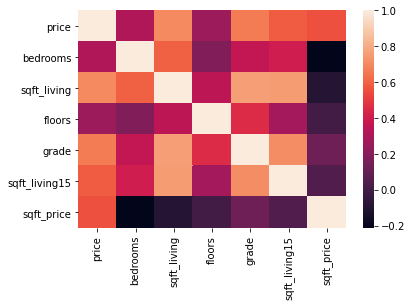

In [14]:
sns.heatmap(df[["price", "bedrooms", "sqft_living", "floors", "grade", "sqft_living15", "sqft_price"]].corr());

While the size of the living area ```sqft_living```, the evaluation ```grade```and the size of neighborhood houses ```sqft_living15``` all seem to strongly positively correlate with ```price```, they do not with ```sqft_price```. For our customer this means that there are houses out there that should be spacious while still being affordable.

## Analysis & revisiting the assumptions

### Timing

In the course of this analysis we will test the assumptions made earlier. The first assumption stated that the (average) prices for houses are different for different months. We look into this matter by plotting the **mean**, **median** and the **lower 25% quantile** of both ```price```and ```sqft_price```per month. We chose these metrics as they relate to the customers budget - their goal is to buy a rather cheap house. To provide more depth to the analysis, we also look at the box plots of ```sqft_price``` per month. The resulting graphs can be found below.

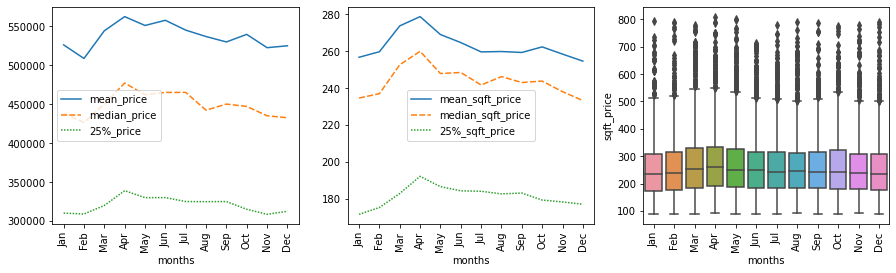

In [33]:
price_mean_monthly = pd.DataFrame(df.groupby("months").price.mean())
price_median_monthly = pd.DataFrame(df.groupby("months").price.median())
price_lowq_monthly = pd.DataFrame(df.groupby("months").price.quantile(0.25))

sqft_price_mean_monthly = df.groupby("months").sqft_price.mean()
sqft_price_median_monthly = df.groupby("months").sqft_price.median()
sqft_price_lowq_monthly = df.groupby("months").sqft_price.quantile(0.25)

month_price_df = pd.merge(price_mean_monthly, price_median_monthly, how="left", on="months")
month_price_df = pd.merge(month_price_df, price_lowq_monthly, how="left", on="months")
month_sqft_price_df = pd.merge(sqft_price_mean_monthly, sqft_price_median_monthly, how="left", on="months")
month_sqft_price_df = pd.merge(month_sqft_price_df, sqft_price_lowq_monthly, how="left", on="months")
month_price_df.columns = ["mean_price", "median_price", "25%_price"]
month_sqft_price_df.columns = ["mean_sqft_price", "median_sqft_price", "25%_sqft_price"]

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,4))

g = sns.lineplot(data=month_price_df, ax=axes[0])
g.set_xticks(range(1, len(month_price_df) + 1)) # <--- set the ticks first
g.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], rotation=90)

g2 = sns.lineplot(data=month_sqft_price_df, ax=axes[1]);
g2.set_xticks(range(1, len(month_price_df) + 1)) # <--- set the ticks first
g2.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], rotation=90)

g0 = sns.boxplot(x='months', y="sqft_price", data=df, ax=axes[2])
g0.set_xticks(range(len(month_price_df))) # <--- set the ticks first
g0.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], rotation=90);

All three figures and their metrics paint a similar picture. Prices, regardless of whether they are total or per square feet, tend to peak in April for all categories considered. Based on this analysis, the period from November to Februar is best fit to buy a house at a comparatively lower price.

### Location

Similar to the timing of buying a house, we assume that it also matters where the house is located. The data of house sales contains the zipcode as information. We again use the three metrics ```mean_sqft_price, median_sqft_price, 25%_sqft_price```from the previous analysis and look into total prices of houses.

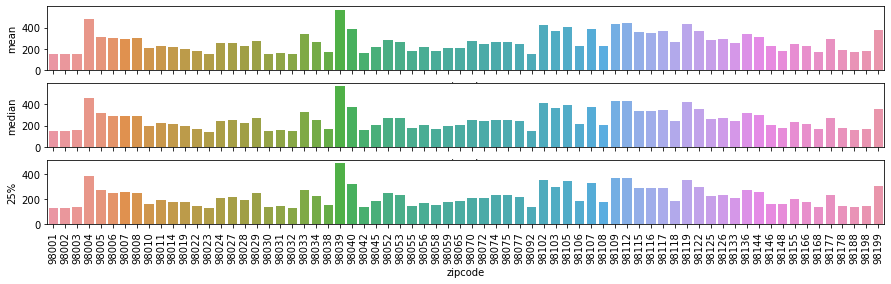

In [37]:
zipcode_sqft_price_df = pd.DataFrame([df.groupby("zipcode").sqft_price.mean(),
                        df.groupby("zipcode").sqft_price.median(),
                        df.groupby("zipcode").sqft_price.quantile(.25)]).transpose()

zipcode_sqft_price_df.columns = ["mean_sqft_price", "median_sqft_price", "25%_sqft_price"]

zipcode_sqft_price_df = zipcode_sqft_price_df.reset_index()

fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(15,4))

g6 = sns.barplot(x="zipcode", y="mean_sqft_price", data=zipcode_sqft_price_df, ax=axes[0]);
g6.set_xticklabels('')
g6.set_ylabel("mean")
g7 = sns.barplot(x="zipcode", y="median_sqft_price", data=zipcode_sqft_price_df, ax=axes[1]);
g7.set_xticklabels('')
g7.set_ylabel("median")
g8 = sns.barplot(x="zipcode", y="25%_sqft_price", data=zipcode_sqft_price_df, ax=axes[2]);
g8.set_xticklabels(zipcode_sqft_price_df["zipcode"], rotation=90)
g8.set_ylabel("25%")
plt.show()

The data suggests that there are zipcodes where living space is in general cheaper than in others. These are the zipcodes that the customer should focus on when looking for a house to purchase.

### Renovated

The next assumption to investigate is whether a renovated house costs more than a house that has not been renovated so far. This is a rather simple analysis that can be executed using boxplots for the two categories of houses.

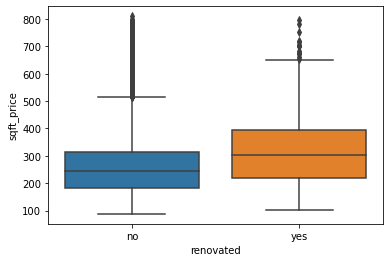

In [17]:
sns.boxplot(x="renovated", y="sqft_price", data=df);

As expected, renovated houses do sell for higher prices than those that have not been renovated. Looking especially for non-renovated houses might be beneficial to the customer.

### Waterfront

Similar to the renovation, resigning from the idea of having a waterfront house could lead to lower house prices. We investigate this using another boxplot.

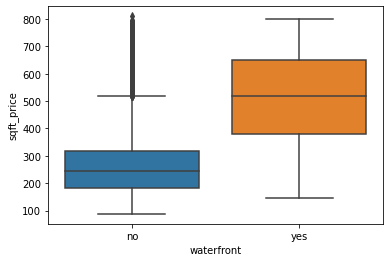

In [18]:
g9 = sns.boxplot(x="waterfront", y="sqft_price", data=df)
g9.set_xticklabels(["no", "yes"]);

The results confirm the suspicion that houses with no waterfront have lower prices.

# Recommendations

While the recommendation regarding the timing of a purchase has already been quite specific, here is a reminder of which months are most favorable for buying living space that is relatively cheap.

In [19]:
month_t = month_sqft_price_df.sort_values(by="25%_sqft_price").reset_index()
month_t

,months,mean_sqft_price,median_sqft_price,25%_sqft_price
0,1,256.773212,234.654631,171.546853
1,2,259.770095,237.016575,175.211864
2,12,254.685079,233.298466,176.998745
3,11,258.495379,238.095238,178.244973
4,10,262.402144,243.855346,179.282975
5,8,259.889913,246.268657,182.638861
6,3,273.811231,252.707581,182.845056
7,9,259.378960,243.083004,183.066468
8,7,259.691581,241.716867,184.036480
9,6,264.749332,248.516129,184.294872


Even though, strictly speaking the cheapest month is different according to which metric we use, April is least favorable and the months from November to February have the lowest prices. We can therefore recommend buying houses during the cold months of the year.

In addition to the analysis of potential locations done previously, we will narrow down potential locations even further here and also display them graphically to provide a better overview. According to the customers preferences and requirements, we will set up a few filters to show where affordable and favorable houses are located within King County.

The filters are gonna be aimed at houses that:
* Have at least 5 bedrooms **(enough for the kids)**
* Are within the lower quantile of price per living space square feet **(affordable)**
* Are above the lower quantile of living space square feet **(good value/size for money)**
* Do not have a waterfront **(good value/size for money)**
* Have not been renovated **(good value/size for money)**
* Are situated in neighborhoods where houses have a living space above the lower quantile **(social neighborhood)**

In [20]:
df_filtered = df.loc[(df.bedrooms >= 5) & (df.sqft_price < df.sqft_price.quantile(.25)) 
                     & (df.sqft_living > df.sqft_living.quantile(.25)) & (df.waterfront == 0) 
                     & (df.sqft_living15 > df.sqft_living15.quantile(.25)) & (df.renovated == "no")]
df_filtered.shape

(525, 24)

The filters lead to 525 houses that fit all the criteria. Let's check their locations.

In [21]:
mean_lat = df_filtered.lat.mean()
mean_long = df_filtered.long.mean()


folium_map = folium.Map(location=[mean_lat ,mean_long],
                        zoom_start=10,
                        tiles='stamenterrain')

FastMarkerCluster(data=list(zip(df_filtered['lat'].values, df_filtered['long'].values))).add_to(folium_map)
folium.LayerControl().add_to(folium_map)
folium_map

The interactive map above shows where houses that satisfy the filters have been sold within the time frame of the data set. This can be used as a guide to where to look for houses that are large yet affordable. Reversely, it can also be used to investigate preferred neighborhoods and check if it is worth looking in that area at all.

To make the search for the right house even easier, we will extract the top ten zipcodes in terms of where the most houses like the one we are looking for have been sold.

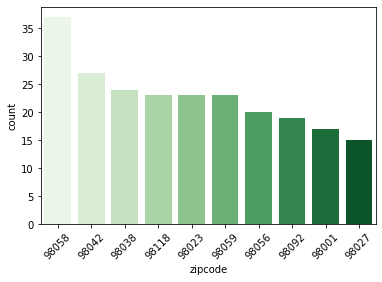

In [38]:
df_filtered_zip = pd.DataFrame(df_filtered.zipcode.value_counts())
df_filtered_zip = df_filtered_zip.reset_index()
df_filtered_zip.columns = ["zipcode", "count"]
df_zip_shortlist = df_filtered_zip.sort_values(by="count", ascending=False)[:10]
df_zip_shortlist.zipcode = df_zip_shortlist.zipcode.astype("str")
g10 = sns.barplot(x="zipcode", y="count", data=df_zip_shortlist, palette="Greens")
g10.set_xticklabels(df_zip_shortlist["zipcode"], rotation=45);

Most promising seem to be zipcodes ```98058, 98042, 98038```!